In [56]:
! pip install -r requirements.txt 
!pip install chardet

In [57]:
!pip install -U --force-reinstall charset-normalizer  

  Using cached charset_normalizer-3.3.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
Using cached charset_normalizer-3.3.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (138 kB)
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 3.3.1
    Uninstalling charset-normalizer-3.3.1:
      Successfully uninstalled charset-normalizer-3.3.1


In [58]:
from modules import U2NET

import os
from PIL import Image
import gdown
import cv2
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from collections import OrderedDict
from utils import opt

In [60]:

def load_checkpoint(model, checkpoint_path):
    if not os.path.exists(checkpoint_path):
        print("----No checkpoints at given path----")
        return
    model_state_dict = torch.load(checkpoint_path, map_location=torch.device("cpu"))
    new_state_dict = OrderedDict()
    for k, v in model_state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    print("----checkpoints loaded from path: {}----".format(checkpoint_path))
    return model


def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette


class Normalize_image(object):
    """Normalize given tensor into given mean and standard dev

    Args:
        mean (float): Desired mean to substract from tensors
        std (float): Desired std to divide from tensors
    """

    def __init__(self, mean, std):
        assert isinstance(mean, (float))
        if isinstance(mean, float):
            self.mean = mean

        if isinstance(std, float):
            self.std = std

        self.normalize_1 = transforms.Normalize(self.mean, self.std)
        self.normalize_3 = transforms.Normalize([self.mean] * 3, [self.std] * 3)
        self.normalize_18 = transforms.Normalize([self.mean] * 18, [self.std] * 18)

    def __call__(self, image_tensor):
        if image_tensor.shape[0] == 1:
            return self.normalize_1(image_tensor)

        elif image_tensor.shape[0] == 3:
            return self.normalize_3(image_tensor)

        elif image_tensor.shape[0] == 18:
            return self.normalize_18(image_tensor)

        else:
            assert "Please set proper channels! Normlization implemented only for 1, 3 and 18"




def apply_transform(img):
    transforms_list = []
    transforms_list += [transforms.ToTensor()]
    transforms_list += [Normalize_image(0.5, 0.5)]
    transform_rgb = transforms.Compose(transforms_list)
    return transform_rgb(img)

def check_or_download_model(file_path):
    if not os.path.exists(file_path):
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        url = "https://huggingface.co/trungtruc/unet_clothes_seg/resolve/main/unet_cloth_seg.pth"
        gdown.download(url, file_path, quiet=False)
        print("Model downloaded successfully.")
    else:
        print("Model already exists.")



def load_seg_model(checkpoint_path, device='cpu'):
    net = U2NET(in_ch=3, out_ch=4)
    check_or_download_model(checkpoint_path)
    net = load_checkpoint(net, checkpoint_path)
    net = net.to(device)
    net = net.eval()

    return net

In [61]:
def generate_mask(input_image, net, palette, device = 'cpu'):

    #img = Image.open(input_image).convert('RGB')
    img = input_image
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)
    image_tensor = apply_transform(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    alpha_out_dir = os.path.join(opt.output,'gray_seg_element')
    cloth_seg_out_dir = os.path.join(opt.output,'clothes_seg')

    os.makedirs(alpha_out_dir, exist_ok=True)
    os.makedirs(cloth_seg_out_dir, exist_ok=True)

    with torch.no_grad():
        output_tensor = net(image_tensor.to(device))
        output_tensor = F.log_softmax(output_tensor[0], dim=1)
        output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
        output_tensor = torch.squeeze(output_tensor, dim=0)
        output_arr = output_tensor.cpu().numpy()

    classes_to_save = []

    # Check which classes are present in the image
    for cls in range(1, 4):  # Exclude background class (0)
        if np.any(output_arr == cls):
            classes_to_save.append(cls)

    # Save alpha masks
    for cls in classes_to_save:
        alpha_mask = (output_arr == cls).astype(np.uint8) * 255
        print('output_arr', output_arr)
        alpha_mask_2d = alpha_mask[0]  # Selecting the first channel to make it 2D

        alpha_mask_img = Image.fromarray(alpha_mask_2d, mode='L')
        alpha_mask_img = alpha_mask_img.resize(img_size, Image.BICUBIC)
        alpha_mask_img.save(os.path.join(alpha_out_dir, f'{cls}.png'))

    # Save final cloth segmentations
    cloth_seg = Image.fromarray(output_arr[0].astype(np.uint8), mode='P')
    cloth_seg.putpalette(palette)
    cloth_seg = cloth_seg.resize(img_size, Image.BICUBIC)
    cloth_seg.save(os.path.join(cloth_seg_out_dir, 'final_seg.png'))
    return cloth_seg


In [62]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Create an instance of your model
net = load_seg_model("model/unet_cloth_seg.pth", device=device)

palette = get_palette(4)
print("palette",palette)
img_name = 'img1.jpg'
path_img = os.path.join('input',img_name)
input_image = Image.open(path_img).convert('RGB')

# cloth_seg = generate_mask(img, net=model, palette=palette, device=device)
    

Model already exists.
----checkpoints loaded from path: model/unet_cloth_seg.pth----
palette [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0]


In [63]:
#img = Image.open(input_image).convert('RGB')
img = input_image
img_size = img.size
img = img.resize((768, 768), Image.BICUBIC)
image_tensor = apply_transform(img)
image_tensor = torch.unsqueeze(image_tensor, 0)

alpha_out_dir = os.path.join(opt.output,'gray_seg_element')
cloth_seg_out_dir = os.path.join(opt.output,'clothes_seg')

os.makedirs(alpha_out_dir, exist_ok=True)
os.makedirs(cloth_seg_out_dir, exist_ok=True)

with torch.no_grad():
    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()

/home/tructt/anaconda3/envs/seg_clothes/lib/python3.8/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [22]:
output_tensor

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [23]:
output_arr

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])

In [64]:

classes_to_save = []

# Check which classes are present in the image
for cls in range(1, 4):  # Exclude background class (0)
    if np.any(output_arr == cls):
        classes_to_save.append(cls)

In [48]:
classes_to_save

[1, 2]

In [65]:



# Save alpha masks
for cls in classes_to_save:
    alpha_mask = (output_arr == cls).astype(np.uint8) * 255
    print('alpha_mask', alpha_mask.shape)
    alpha_mask_2d = alpha_mask[0]  # Selecting the first channel to make it 2D

    alpha_mask_img = Image.fromarray(alpha_mask_2d, mode='L')
    alpha_mask_img = alpha_mask_img.resize(img_size, Image.BICUBIC)
    alpha_mask_img.show()
    alpha_mask_img.save(os.path.join(alpha_out_dir, f'{img_name[:-4]}_{cls}.png'))

alpha_mask (1, 768, 768)
alpha_mask (1, 768, 768)


In [66]:
# Save final cloth segmentations
cloth_seg = Image.fromarray(output_arr[0].astype(np.uint8), mode='P')
cloth_seg.putpalette(palette)
cloth_seg = cloth_seg.resize(img_size, Image.BICUBIC)
cloth_seg.save(os.path.join(cloth_seg_out_dir, f'{img_name[:-4]}_final.png'))

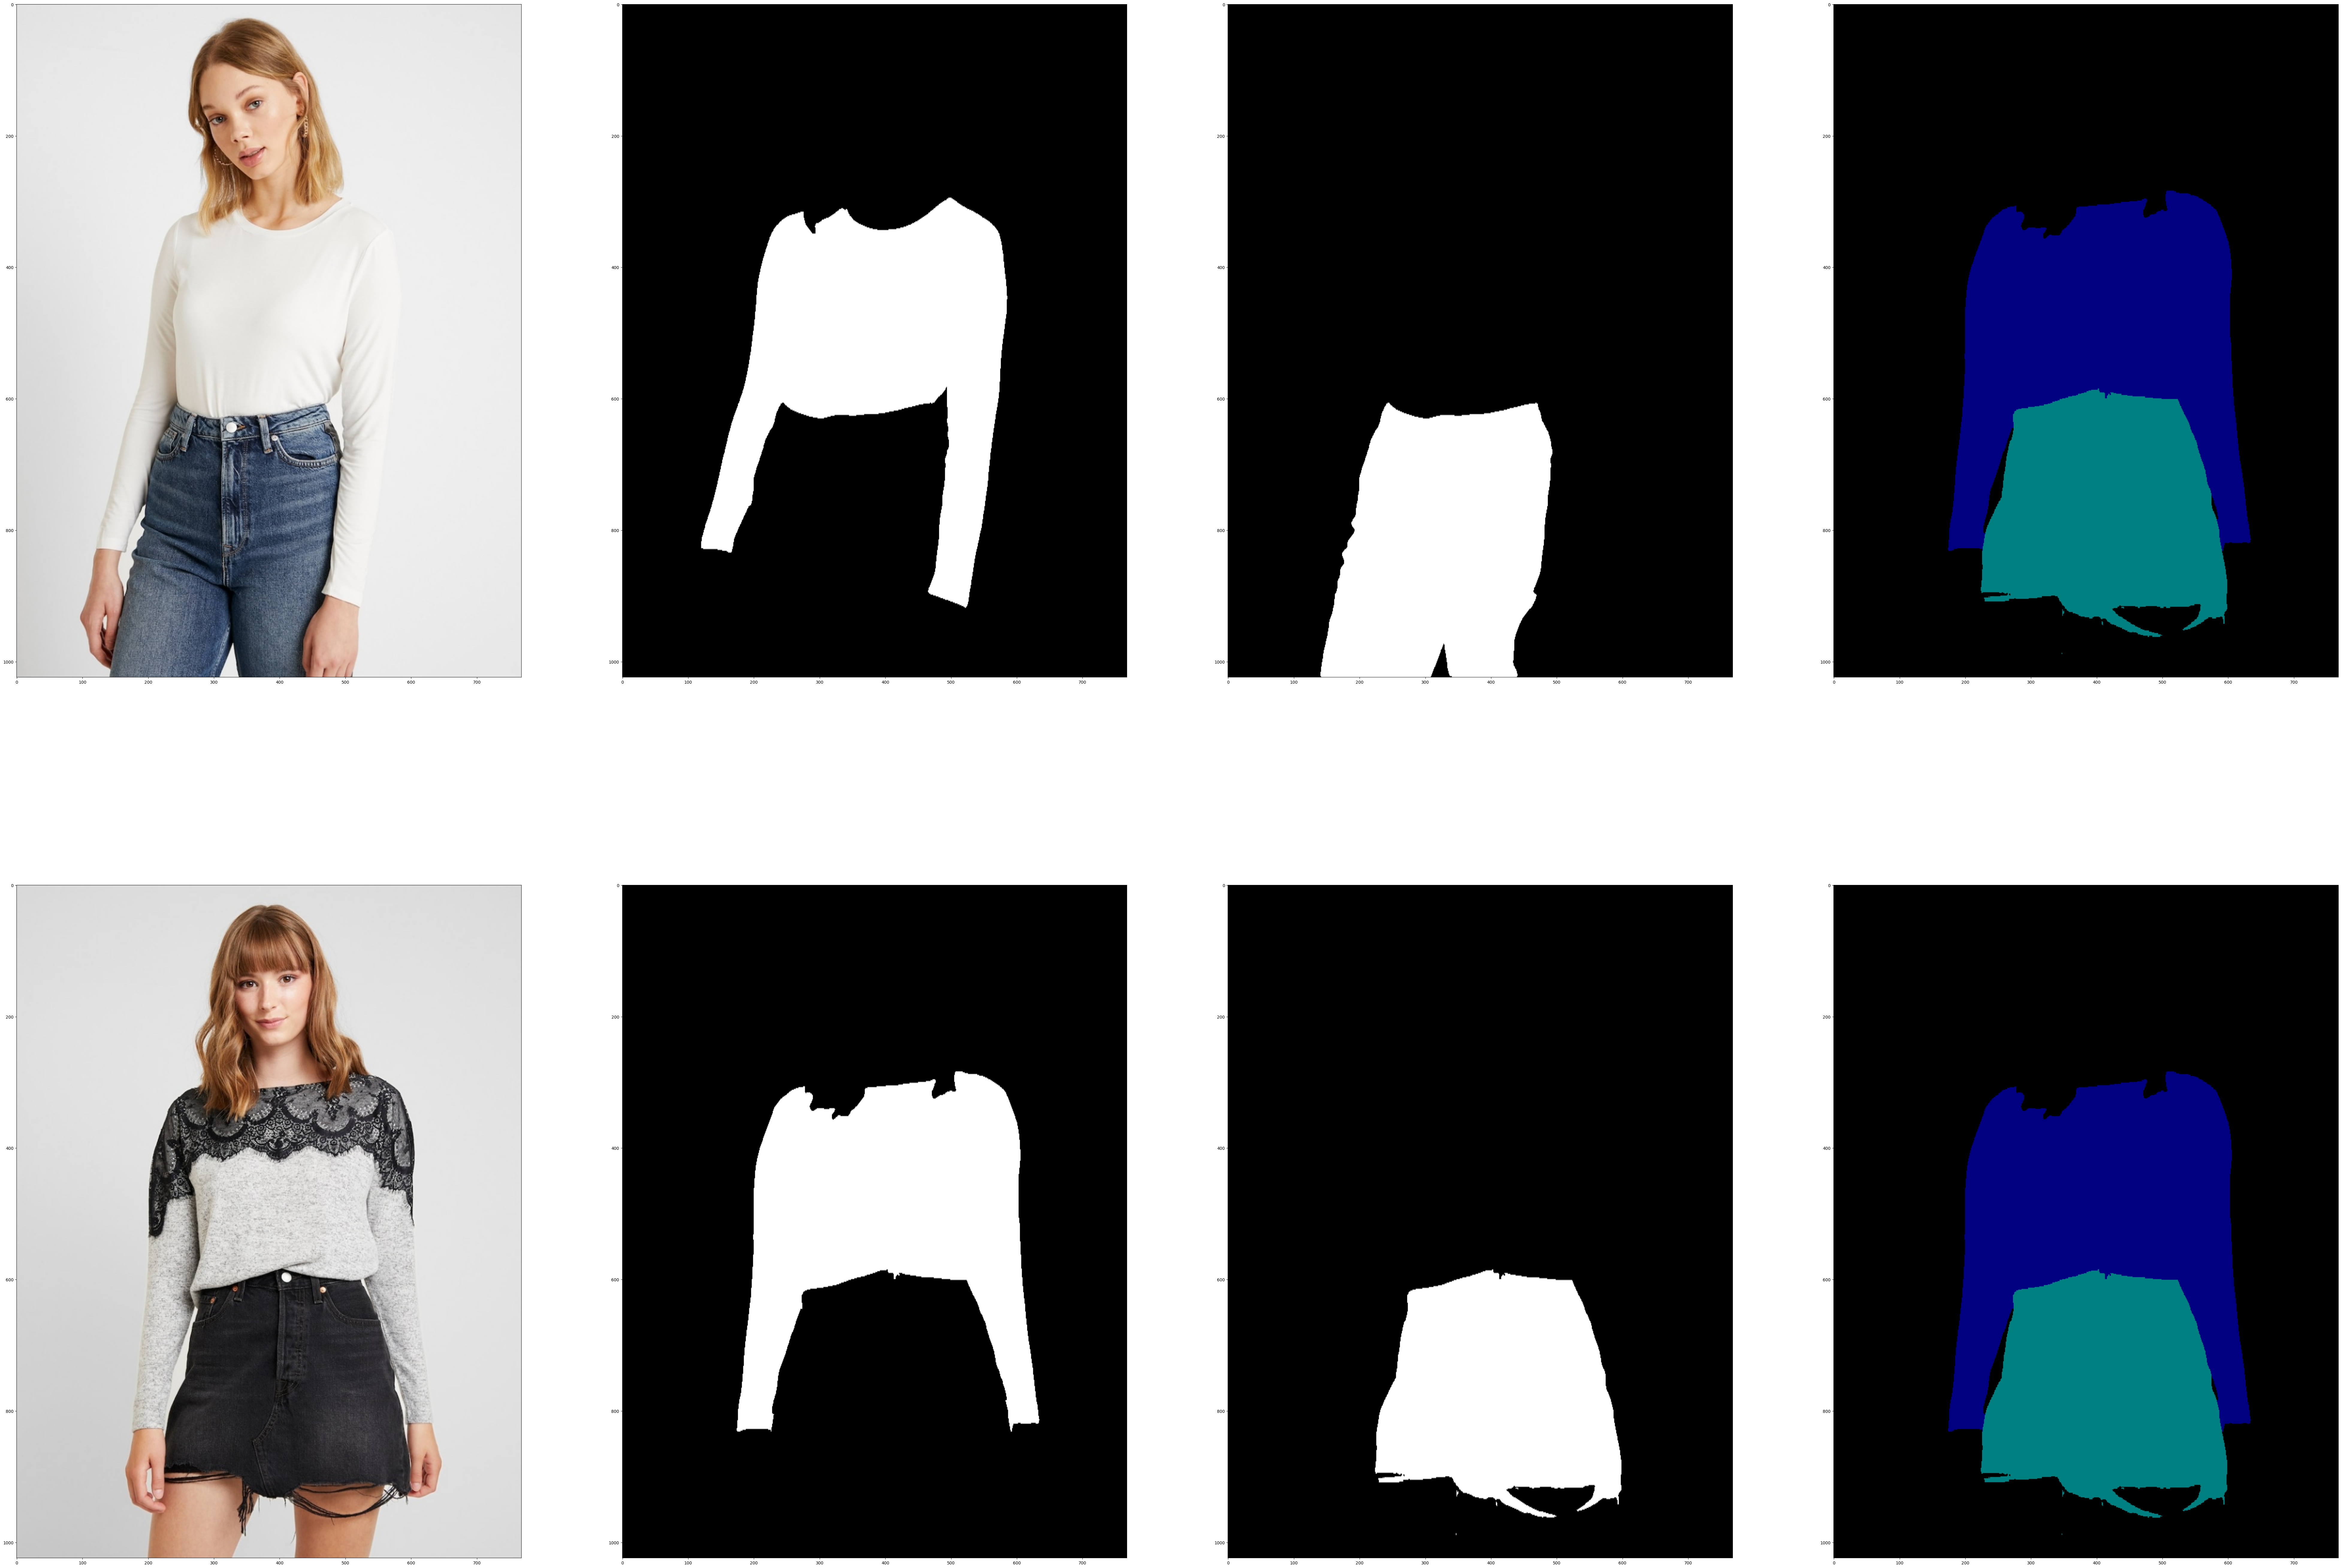

In [67]:

# code for displaying multiple images in one figure 
  
#import libraries 
import cv2 
from matplotlib import pyplot as plt 
  
# create figure 
fig = plt.figure(figsize=(100, 70)) 
  
# setting values to rows and column variables 
rows = 2
columns =4
  
# reading images 

image1 = cv2.imread('input/img1.jpg') 
img1_gray_1 = cv2.imread('output/gray_seg_element/img1_1.png') 
img1_gray_2 = cv2.imread('output/gray_seg_element/img1_2.png') 
img1_final = cv2.imread('output/clothes_seg/img2_final.png') 

image2 = cv2.imread('input/img2.jpg') 
img2_gray_1 = cv2.imread('output/gray_seg_element/img2_1.png') 
img2_gray_2 = cv2.imread('output/gray_seg_element/img2_3.png') 
img2_final = cv2.imread('output/clothes_seg/img2_final.png') 
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
# showing image 
image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
pixels = np.array(image)
plt.imshow(pixels) 
fig.add_subplot(rows, columns, 2) 
# showing image 
plt.imshow(img1_gray_1) 
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
# showing image 
plt.imshow(img1_gray_2) 
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 
# showing image 
plt.imshow(img1_final) 


fig.add_subplot(rows, columns, 5)
# showing image 
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
pixels = np.array(image2)
plt.imshow(pixels) 
fig.add_subplot(rows, columns, 6) 
# showing image 
plt.imshow(img2_gray_1) 
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 7) 
# showing image 
plt.imshow(img2_gray_2) 
# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 8) 
# showing image 
plt.imshow(img2_final) 

#save fig
plt.savefig(os.path.join("output","show_segment.jpg"))


#   TO IMPROVE QUALITY SEGMENTATION

In [69]:
import cv2
import numpy as np
import os
img = cv2.imread('output/gray_seg_element/img2_3.png', cv2.IMREAD_GRAYSCALE)
img_final = cv2.imread("output/clothes_seg/img2_final.png")
assert img is not None, "file could not be read, check with os.path.exists()"
kernel = np.ones((5,5),np.uint8)
remove_noise_bg_img = cv2.morphologyEx(img_final, cv2.MORPH_OPEN, kernel)

# blur =  cv2.blur(img_final,(5,5))
# gaussianBlur = cv2.GaussianBlur(img_final,(5,5),0)
erosion = cv2.erode(remove_noise_bg_img,kernel,iterations = 1)
dilate = cv2.dilate(remove_noise_bg_img,kernel,iterations= 1)

file_path = "output/segment_improve"
if not os.path.exists(file_path):
    # os.makedirs(os.path.dirname(file_path), exist_ok=True)
    os.mkdir(file_path)
cv2.imwrite(os.path.join("output/segment_improve","img.png"), img_final)
cv2.imwrite(os.path.join("output/segment_improve","img_erosion.png"), erosion)
cv2.imwrite(os.path.join("output/segment_improve","img_dilate.png"), dilate)
# cv2.imshow("img",img_final)
# cv2.imshow("blur", blur)
# cv2.imshow("gaussian_blur", gaussianBlur)
# cv2.imshow("rm_noise",remove_noise_bg_img)
# cv2.imshow("img erosion", erosion)
# cv2.imshow("img dilate", dilate)
# cv2.waitKey(0)

True